<h1 align="center">CS598: Deep Learning for Healthcare Final Project</h1>
<h3 align="center">Team #164</h3>
<h3 align="center">Team member: Zexi Yan</h3>
<h3 align="center">Corresponding emails: zexiyan2@illinois.edu</h3>
<h3 align="center">Github Repo: https://github.com/ericyan3000/CS598-DLH-Chet.git</h3>



# **Introduction**

###   Background of the problem
The primary challenge addressed by the paper is the limitation of existing health event prediction models which consider diagnoses as independent entities, neglecting the clinical relationships among diseases. This oversight hinders the ability to effectively utilize combinational disease information and understand the dynamic nature of disease development over time. This leads to the two problems the paper is trying to address.
- Disease combinations in medical practice form a global graph structure that reveals hidden patterns among diseases, with individual patient visits represented as local subgraphs. Despite the potential to predict future health events by analyzing these structures, common deep learning models like GRAM [2], Timeline [3], and G-BERT [4] do not utilize this graph structure for health event predictions.
- The progression of a disease in a patient is dynamic, as evidenced by changing diagnosis priorities and the emergence of new diagnoses in EHR datasets like MIMIC-III [5]. This dynamic nature, where diseases evolve and impact patients differently over time, suggests the need for a model that can dynamically represent disease development and learn the transition from potential to actual diagnoses.
###   Paper explanation
The paper titled "Context-aware Health Event Prediction via Transition Functions on Dynamic Disease Graphs" [1] introduces a novel framework for improving health event predictions by incorporating dynamic disease relationships within EHR data. The authors propose a sophisticated model that constructs and utilizes dynamic disease graphs to represent the evolving relationships between different diagnoses as patients continue to visit healthcare facilities.

The innovation of the method lies in its ability to dynamically adjust disease representations and interactions based on a patient's history and current health state. This is achieved through the use of global disease co-occurrence graphs and patient-specific subgraphs, which adapt based on new health information. The model uses transition functions to model the changes in disease relevance and connections, reflecting the natural progression and regression of disease states over time. 

In terms of effectiveness, the proposed method has shown to outperform existing models significantly, as demonstrated through rigorous testing on real-world EHR datasets. The results indicated improvements in prediction accuracy for various health events, showcasing the model's capability to handle the complex dynamics of disease progression.


# **Scope of Reproducibility:**

### Model Implementation:
We aim to implement the Chet model based on the descriptions and methodologies outlined in the original paper [1]. This includes constructing the global disease co-occurrence graph, designing dynamic subgraphs for patient visits, and defining diagnosis roles that model the transition processes of diseases. The correctness of the implementation will be verified by comparing the architectural integrity and model evaluation metrics against those described in the paper.

### Experimental Reproduction:
We will replicate the experiments conducted in the original study for the heart failure prediction task only. The evaluation metrics - weighted AUC, F1 score and test loss - will be used to assess the model performance. Our goal is to achieve results within a comparable range to those reported in the original paper.

### Ablation Study
The ablation study aims to quantify the contribution of the transition functions to the overall performance of the Chet model. By removing or modifying key components of the model, we can isolate and understand their individual impacts. For this project, we will specifically focus on the role of the transition functions, which are central to the model's ability to dynamically integrate historical context and disease progression across patient visits and diagonistic codes.

Running environments, datasets, model implementation, hyperparameters and model training, albation study and analysis of results will be discussed in details in further sessions below.

### 

# **Methodology**

### Environment

The following shows the python version and imports all required dependencies/packages for this project.

In [37]:
import sys
import os
import _pickle as pickle
import math
import torch
from torch import nn
import time
import numpy as np
from datetime import datetime
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, roc_auc_score


has_gpu = torch.cuda.is_available()
has_mps = has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

# print python and package versions
print('Python version: {}'.format(sys.version))
print('PyTorch version: {}'.format(torch.__version__))
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print("Using device:", device) # cuda, mps, cpu


Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
PyTorch version: 1.13.1+cu116
NVIDIA/CUDA GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Using device: cuda


### Data

#### Data download
Our reproduction will use the same public datasets mentioned in the study — MIMIC-III. This choice ensures that any differences in performance metrics can be attributed to the model implementation and not variations in data. <br>

The data is available in https://physionet.org/content/mimiciii/1.4/. The only two datasets used in this project is `ADMISSIONS.csv` and `DIAGNOSES_ICD.csv`. These two files should be placed under the directory `data\mimic3\raw` for data pre-processing.

#### Preprocessing code + command

Data Parser<br>

The data parser `EHRParser` is designed to process Electronic Health Record (EHR) data from specified file paths. It is structured to handle and parse different components of EHRs, including patient admissions and diagnostic codes. It also filtered disqualifed entries from dataset for smoother downstream processing.

In [38]:
class EHRParser:

    '''
    pid_col, adm_id_col, adm_time_col, cid_col: These attributes store the column names used for 
    patient ID, admission ID, admission time, and code ID respectively, which are used across 
    various methods to access data fields in EHR datasets.
    '''
    pid_col = 'pid'
    adm_id_col = 'adm_id'
    adm_time_col = 'adm_time'
    cid_col = 'cid'

    def __init__(self, path):
        self.path = path

        self.skip_pid_check = False

        self.patient_admission = None
        self.admission_codes = None
        self.admission_procedures = None
        self.admission_medications = None

        self.parse_fn = {'d': self.set_diagnosis}

    def set_admission(self):
        raise NotImplementedError

    def set_diagnosis(self):
        raise NotImplementedError

    @staticmethod
    def to_standard_icd9(code: str):
        raise NotImplementedError

    '''
    Parses patient admission data from a CSV file, extracts relevant columns, and organizes admissions by patient ID into ordered dictionaries.
    '''
    def parse_admission(self):
        print('parsing the csv file of admission ...')
        filename, cols, converters = self.set_admission()
        admissions = pd.read_csv(os.path.join(self.path, filename), usecols=list(cols.values()), converters=converters)
        admissions = self._after_read_admission(admissions, cols)
        all_patients = OrderedDict()
        for i, row in admissions.iterrows():
            if i % 100 == 0:
                print('\r\t%d in %d rows' % (i + 1, len(admissions)), end='')
            pid, adm_id, adm_time = row[cols[self.pid_col]], row[cols[self.adm_id_col]], row[cols[self.adm_time_col]]
            if pid not in all_patients:
                all_patients[pid] = []
            admission = all_patients[pid]
            admission.append({self.adm_id_col: adm_id, self.adm_time_col: adm_time})
        print('\r\t%d in %d rows' % (len(admissions), len(admissions)))

        patient_admission = OrderedDict()
        for pid, admissions in all_patients.items():
            if len(admissions) >= 2:
                patient_admission[pid] = sorted(admissions, key=lambda admission: admission[self.adm_time_col])

        self.patient_admission = patient_admission

    def _after_read_admission(self, admissions, cols):
        return admissions

    '''
    parse and process concept data related to patient healthcare records, such as diagnoses or treatments, based on a specified concept_type.
    '''
    def _parse_concept(self, concept_type):
        assert concept_type in self.parse_fn.keys()
        filename, cols, converters = self.parse_fn[concept_type]()
        concepts = pd.read_csv(os.path.join(self.path, filename), usecols=list(cols.values()), converters=converters)
        concepts = self._after_read_concepts(concepts, concept_type, cols)
        result = OrderedDict()
        for i, row in concepts.iterrows():
            if i % 100 == 0:
                print('\r\t%d in %d rows' % (i + 1, len(concepts)), end='')
            pid = row[cols[self.pid_col]]
            if self.skip_pid_check or pid in self.patient_admission:
                adm_id, code = row[cols[self.adm_id_col]], row[cols[self.cid_col]]
                if code == '':
                    continue
                if adm_id not in result:
                    result[adm_id] = []
                codes = result[adm_id]
                codes.append(code)
        print('\r\t%d in %d rows' % (len(concepts), len(concepts)))
        return result

    def _after_read_concepts(self, concepts, concept_type, cols):
        return concepts

    '''
    parses diagnostic codes associated with admissions
    '''
    def parse_diagnoses(self):
        print('parsing csv file of diagnosis ...')
        self.admission_codes = self._parse_concept('d')

    '''
    calibrates patient records by ensuring that each patient has at least one admission record with diagnostic codes.
    '''
    def calibrate_patient_by_admission(self):
        print('calibrating patients by admission ...')
        del_pids = []
        for pid, admissions in self.patient_admission.items():
            for admission in admissions:
                adm_id = admission[self.adm_id_col]
                if adm_id not in self.admission_codes:
                    break
            else:
                continue
            del_pids.append(pid)
        for pid in del_pids:
            admissions = self.patient_admission[pid]
            for admission in admissions:
                adm_id = admission[self.adm_id_col]
                for concepts in [self.admission_codes]:
                    if adm_id in concepts:
                        del concepts[adm_id]
            del self.patient_admission[pid]

    '''
    calibrates admission records by ensuring that each admission record has at least one diagnostic code.
    '''
    def calibrate_admission_by_patient(self):
        print('calibrating admission by patients ...')
        adm_id_set = set()
        for admissions in self.patient_admission.values():
            for admission in admissions:
                adm_id_set.add(admission[self.adm_id_col])
        del_adm_ids = [adm_id for adm_id in self.admission_codes if adm_id not in adm_id_set]
        for adm_id in del_adm_ids:
            del self.admission_codes[adm_id]

    '''
    samples a subset of patients from the dataset
    '''
    def sample_patients(self, sample_num, seed):
        np.random.seed(seed)
        keys = list(self.patient_admission.keys())
        selected_pids = np.random.choice(keys, sample_num, False)
        self.patient_admission = {pid: self.patient_admission[pid] for pid in selected_pids}
        admission_codes = dict()
        for admissions in self.patient_admission.values():
            for admission in admissions:
                adm_id = admission[self.adm_id_col]
                admission_codes[adm_id] = self.admission_codes[adm_id]
        self.admission_codes = admission_codes

    def parse(self, sample_num=None, seed=1000):
        self.parse_admission()
        self.parse_diagnoses()
        self.calibrate_patient_by_admission()
        self.calibrate_admission_by_patient()
        if sample_num is not None:
            self.sample_patients(sample_num, seed)
        return self.patient_admission, self.admission_codes

In [39]:
class Mimic3Parser(EHRParser):
    def set_admission(self):
        filename = 'ADMISSIONS.csv'
        cols = {self.pid_col: 'SUBJECT_ID', self.adm_id_col: 'HADM_ID', self.adm_time_col: 'ADMITTIME'}
        converter = {
            'SUBJECT_ID': int,
            'HADM_ID': int,
            'ADMITTIME': lambda cell: datetime.strptime(str(cell), '%Y-%m-%d %H:%M:%S')
        }
        return filename, cols, converter

    def set_diagnosis(self):
        filename = 'DIAGNOSES_ICD.csv'
        cols = {self.pid_col: 'SUBJECT_ID', self.adm_id_col: 'HADM_ID', self.cid_col: 'ICD9_CODE'}
        converter = {'SUBJECT_ID': int, 'HADM_ID': int, 'ICD9_CODE': Mimic3Parser.to_standard_icd9}
        return filename, cols, converter

    @staticmethod
    def to_standard_icd9(code: str):
        code = str(code)
        if code == '':
            return code
        split_pos = 4 if code.startswith('E') else 3
        icd9_code = code[:split_pos] + '.' + code[split_pos:] if len(code) > split_pos else code
        return icd9_code

Dataset Configuration and Loading

In [40]:
# Configuration for dataset processing specific to the Mimic3 dataset
conf = {'mimic3': {
        'parser': Mimic3Parser,
        'train_num': 6000,
        'test_num': 1000,
        'threshold': 0.01,
        'seed': 1234
    }
}

# Flag to determine if data should be loaded from previously saved files
from_saved = True
data_path = 'data'
dataset = 'mimic3' 
dataset_path = os.path.join(data_path, dataset)
raw_path = os.path.join(dataset_path, 'raw')

# Check if raw data directory exists, create if not and prompt for data placement
if not os.path.exists(raw_path):
    os.makedirs(raw_path)
    print('please put the CSV files in `data/%s/raw`' % dataset)
    exit()

# Path for storing parsed data
parsed_path = os.path.join(dataset_path, 'parsed')

# Load or parse data depending on `from_saved` flag
if from_saved:
    # Load previously saved parsed data
    patient_admission = pickle.load(open(os.path.join(parsed_path, 'patient_admission.pkl'), 'rb'))
    admission_codes = pickle.load(open(os.path.join(parsed_path, 'admission_codes.pkl'), 'rb'))
else:
    # Parse new data from raw files
    parser = conf[dataset]['parser'](raw_path)
    sample_num = conf[dataset].get('sample_num', None)
    seed = conf[dataset]['seed']
    patient_admission, admission_codes = parser.parse(sample_num, seed)
    print('saving parsed data ...')
    if not os.path.exists(parsed_path):
        os.makedirs(parsed_path)
    pickle.dump(patient_admission, open(os.path.join(parsed_path, 'patient_admission.pkl'), 'wb'))
    pickle.dump(admission_codes, open(os.path.join(parsed_path, 'admission_codes.pkl'), 'wb'))

Statistics of admission and diagnostic codes data

In [41]:
# Calculate various statistics from the patient admissions data
patient_num = len(patient_admission)
max_admission_num = max([len(admissions) for admissions in patient_admission.values()])
avg_admission_num = sum([len(admissions) for admissions in patient_admission.values()]) / patient_num
max_visit_code_num = max([len(codes) for codes in admission_codes.values()])
avg_visit_code_num = sum([len(codes) for codes in admission_codes.values()]) / len(admission_codes)
print('patient num: %d' % patient_num)
print('max admission num: %d' % max_admission_num)
print('mean admission num: %.2f' % avg_admission_num)
print('max code num in an admission: %d' % max_visit_code_num)
print('mean code num in an admission: %.2f' % avg_visit_code_num)

patient num: 7493
max admission num: 42
mean admission num: 2.66
max code num in an admission: 39
mean code num in an admission: 13.06


Encoding of medical codes, generation of hierarchical levels for these codes, and the serialization of the results for later use.

In [42]:
from preprocess.auxiliary import parse_icd9_range

def encode_code(patient_admission, admission_codes):
    
    '''
    Map each unique medical code to a unique integer. 
    '''
    code_map = OrderedDict()
    for pid, admissions in patient_admission.items():
        for admission in admissions:
            codes = admission_codes[admission[EHRParser.adm_id_col]]
            for code in codes:
                if code not in code_map:
                    code_map[code] = len(code_map)

    '''
    Encode medical codes for each admission using the integer mapping.
    '''
    admission_codes_encoded = {
        admission_id: list(set(code_map[code] for code in codes))
        for admission_id, codes in admission_codes.items()
    }
    return admission_codes_encoded, code_map

'''
processes a given mapping of medical codes to numerical identifiers (code_map) and 
generates a matrix that assigns a hierarchical level structure to each code. 
'''
def generate_code_levels(path, code_map: dict) -> np.ndarray:
    print('generating code levels ...')
    import os
    three_level_code_set = set(code.split('.')[0] for code in code_map)
    icd9_path = os.path.join(path, 'icd9.txt')
    icd9_range = list(open(icd9_path, 'r', encoding='utf-8').readlines())
    three_level_dict = dict()
    level1, level2, level3 = (0, 0, 0)
    level1_can_add = False
    for range_ in icd9_range:
        range_ = range_.rstrip()
        if range_[0] == ' ':
            prefix, format_, start, end = parse_icd9_range(range_)
            level2_cannot_add = True
            for i in range(start, end + 1):
                code = prefix + format_ % i
                if code in three_level_code_set:
                    three_level_dict[code] = [level1, level2, level3]
                    level3 += 1
                    level1_can_add = True
                    level2_cannot_add = False
            if not level2_cannot_add:
                level2 += 1
        else:
            if level1_can_add:
                level1 += 1
                level1_can_add = False

    code_level = dict()
    for code, cid in code_map.items():
        three_level_code = code.split('.')[0]
        three_level = three_level_dict[three_level_code]
        code_level[code] = three_level + [cid]

    code_level_matrix = np.zeros((len(code_map), 4), dtype=int)
    for code, cid in code_map.items():
        code_level_matrix[cid] = code_level[code]

    return code_level_matrix

# Encode diagnosis codes and generate a code map
print('encoding code ...')
admission_codes_encoded, code_map = encode_code(patient_admission, admission_codes)
code_num = len(code_map)
print('There are %d codes' % code_num)

# Generate levels for each code and save
code_levels = generate_code_levels(data_path, code_map)
pickle.dump({
    'code_levels': code_levels,
}, open(os.path.join(parsed_path, 'code_levels.pkl'), 'wb'))


encoding code ...
There are 4880 codes
generating code levels ...


Split the data into `train`, `validation` and `test` group.

In [43]:
'''
1. Patients who have admissions containing any of the codes are added to common_pids. This step ensures 
that at least one admission from these patients will be included in the training dataset, as these 
patients are considered to have significant or relevant data.
2. To further ensure the diversity and information richness of the training set, the function identifies 
the patient with the maximum number of admissions and adds this patient to common_pids.
'''

def split_patients(patient_admission, admission_codes, code_map, train_num, test_num, seed=1000):
    print("train_num: %d, test_num: %d" % (train_num, test_num))
    np.random.seed(seed)
    common_pids = set()
    for i, code in enumerate(code_map):
        print('\r\t%.2f%%' % ((i + 1) * 100 / len(code_map)), end='')
        for pid, admissions in patient_admission.items():
            for admission in admissions:
                codes = admission_codes[admission[EHRParser.adm_id_col]]
                if code in codes:
                    common_pids.add(pid)
                    break
            else:
                continue
            break
    #print('\r\t100%')
    max_admission_num = 0
    pid_max_admission_num = 0
    for pid, admissions in patient_admission.items():
        if len(admissions) > max_admission_num:
            max_admission_num = len(admissions)
            pid_max_admission_num = pid
    common_pids.add(pid_max_admission_num)
    print("\rcommon_pids: %d" % len(common_pids))
    remaining_pids = np.array(list(set(patient_admission.keys()).difference(common_pids)))
    print("remaining_pids: %d" % len(remaining_pids))
    np.random.shuffle(remaining_pids)

    valid_num = len(patient_admission) - train_num - test_num
    train_pids = np.array(list(common_pids.union(set(remaining_pids[:(train_num - len(common_pids))].tolist()))))
    valid_pids = remaining_pids[(train_num - len(common_pids)):(train_num + valid_num - len(common_pids))]
    test_pids = remaining_pids[(train_num + valid_num - len(common_pids)):]
    return train_pids, valid_pids, test_pids

# Split patients into training, validation, and test sets
train_pids, valid_pids, test_pids = split_patients(
    patient_admission=patient_admission,
    admission_codes=admission_codes,
    code_map=code_map,
    train_num=conf[dataset]['train_num'],
    test_num=conf[dataset]['test_num']
)
print('There are %d train, %d valid, %d test samples' % (len(train_pids), len(valid_pids), len(test_pids)))



train_num: 6000, test_num: 1000


	26.05%

common_pids: 2281
remaining_pids: 5212
There are 6000 train, 493 valid, 1000 test samples


Construct an adjacency matrix for medical codes based on their co-occurrence within patient records in a training dataset. This matrix will serve as a graphical representation of the relationships between different medical codes, where each code represents a node in the graph, and connections (edges) between nodes indicate that the corresponding medical codes have appeared together within one or more patient admissions.

In [44]:
from preprocess.auxiliary import normalize_adj

def generate_code_code_adjacent(pids, patient_admission, admission_codes_encoded, code_num, threshold=0.01):
    print('generating code code adjacent matrix ...')
    n = code_num
    adj = np.zeros((n, n), dtype=int)
    for i, pid in enumerate(pids):
        print('\r\t%d / %d' % (i, len(pids)), end='')
        for admission in patient_admission[pid]:
            codes = admission_codes_encoded[admission[EHRParser.adm_id_col]]
            for row in range(len(codes) - 1):
                for col in range(row + 1, len(codes)):
                    c_i = codes[row]
                    c_j = codes[col]
                    adj[c_i, c_j] += 1
                    adj[c_j, c_i] += 1
    print('\r\t%d / %d' % (len(pids), len(pids)))
    norm_adj = normalize_adj(adj)
    a = norm_adj < threshold
    b = adj.sum(axis=-1, keepdims=True) > (1 / threshold)
    adj[np.logical_and(a, b)] = 0
    return adj

code_adj = generate_code_code_adjacent(pids=train_pids, patient_admission=patient_admission,
                                        admission_codes_encoded=admission_codes_encoded,
                                        code_num=code_num, threshold=conf[dataset]['threshold'])

generating code code adjacent matrix ...
	6000 / 6000


In [45]:
from preprocess.build_dataset import build_code_xy
from preprocess.auxiliary import generate_neighbors

# Additional data processing for training, validation, and test sets
common_args = [patient_admission, admission_codes_encoded, max_admission_num, code_num]
print('building train codes features and labels ...')
(train_code_x, train_codes_y, train_visit_lens) = build_code_xy(train_pids, *common_args)
print('building valid codes features and labels ...')
(valid_code_x, valid_codes_y, valid_visit_lens) = build_code_xy(valid_pids, *common_args)
print('building test codes features and labels ...')
(test_code_x, test_codes_y, test_visit_lens) = build_code_xy(test_pids, *common_args)

# Generate neighbor nodes for training, validation, and test sets
print('generating train neighbors ...')
train_neighbors = generate_neighbors(train_code_x, train_visit_lens, code_adj)
print('generating valid neighbors ...')
valid_neighbors = generate_neighbors(valid_code_x, valid_visit_lens, code_adj)
print('generating test neighbors ...')
test_neighbors = generate_neighbors(test_code_x, test_visit_lens, code_adj)

building train codes features and labels ...
	6000 / 6000
building valid codes features and labels ...
	493 / 493
building test codes features and labels ...
	1000 / 1000
generating train neighbors ...
	6000 / 6000
generating valid neighbors ...
	493 / 493
generating test neighbors ...
	1000 / 1000


The below `divide_middle` function plays a critical role within the framework described in the paper [1], which emploies constructing a global disease co-occurrence graph and designing dynamic subgraphs for each patient visit. The utility of this function categorizes diseases (or medical codes) into three distinct roles during each patient visit, reflecting the conceptual model of disease transitions. These roles are `diagnosis`, `diagnosis-neighbor`, `neighbors`. Together they construct the `dyanmic local subgraphs` as in the following image [1]

<p align="center"> <img src="images\image_1.jpg" alt="Image 1"> </p>



In [46]:
def divide_middle(code_x, neighbors, lens):
    n = len(code_x)
    divided = np.zeros((*code_x.shape, 3), dtype=bool)
    for i, admissions in enumerate(code_x):
        print('\r\t%d / %d' % (i + 1, n), end='')
        divided[i, 0, :, 0] = admissions[0]
        for j in range(1, lens[i]):
            codes_set = set(np.where(admissions[j] == 1)[0])
            m_set = set(np.where(admissions[j - 1] == 1)[0])
            n_set = set(np.where(neighbors[i][j - 1] == 1)[0])
            m1 = codes_set.intersection(m_set)
            m2 = codes_set.intersection(n_set)
            m3 = codes_set.difference(m_set).difference(n_set)
            if len(m1) > 0:
                divided[i, j, np.array(list(m1)), 0] = 1
            if len(m2) > 0:
                divided[i, j, np.array(list(m2)), 1] = 1
            if len(m3) > 0:
                divided[i, j, np.array(list(m3)), 2] = 1
    print('\r\t%d / %d' % (n, n))
    return divided

print('generating train middles ...')
train_divided = divide_middle(train_code_x, train_neighbors, train_visit_lens)
print('generating valid middles ...')
valid_divided = divide_middle(valid_code_x, valid_neighbors, valid_visit_lens)
print('generating test middles ...')
test_divided = divide_middle(test_code_x, test_neighbors, test_visit_lens)


generating train middles ...


	1350 / 6000

	2598 / 6000

	6000 / 6000
generating valid middles ...
	493 / 493
generating test middles ...
	1000 / 1000


Generate labels for a dataset specifically identifying cases of heart failure based on medical code `428`. 

In [47]:
from preprocess.build_dataset import build_heart_failure_y

print('building train heart failure labels ...')
train_hf_y = build_heart_failure_y('428', train_codes_y, code_map)
print('building valid heart failure labels ...')
valid_hf_y = build_heart_failure_y('428', valid_codes_y, code_map)
print('building test heart failure labels ...')
test_hf_y = build_heart_failure_y('428', test_codes_y, code_map)

building train heart failure labels ...
building valid heart failure labels ...
building test heart failure labels ...


Show statistics for heart failure datasets. The counts of heart failure are about 1:3 in all three datasets.

2121 patients have heart failure out of 6000 patients
162 patients have heart failure out of 493 patients
373 patients have heart failure out of 1000 patients


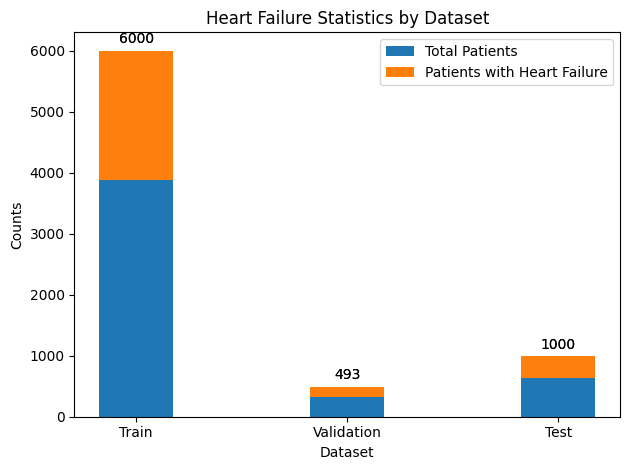

In [48]:
from preprocess.auxiliary import show_heart_failure_stat

train_hf_count, train_total = show_heart_failure_stat('428', train_codes_y, code_map)
valid_hf_count, valid_total = show_heart_failure_stat('428', valid_codes_y, code_map)
test_hf_count, test_total = show_heart_failure_stat('428', test_codes_y, code_map)


# Data
labels = ['Train', 'Validation', 'Test']
hf_counts = [train_hf_count, valid_hf_count, test_hf_count]
total_counts = [train_total, valid_total, test_total]

# Plotting
x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, total_counts, width, label='Total Patients')
rects2 = ax.bar(x, hf_counts, width, label='Patients with Heart Failure', bottom=total_counts - np.array(hf_counts))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Dataset')
ax.set_ylabel('Counts')
ax.set_title('Heart Failure Statistics by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# **Model**

### Original Paper 
Lu, Chang, Tian Han, and Yue Ning. "Context-aware health event prediction via transition functions on dynamic disease graphs." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 36, no. 4, pp. 4567-4574. 2022. <br>
[Original Paper Link](https://arxiv.org/abs/2112.05195) <br>
[Original Paper Repo](https://github.com/LuChang-CS/Chet)

### Model Description
The Chet model effectively incorporates both global and local contexts by constructing a global disease co-occurrence graph, which captures broad relationships among various diseases across different patients and healthcare settings. Additionally, for each patient visit, Chet designs dynamic subgraphs tailored to the specific medical history and the conditions of the patient.

### Key Components of the Chet Model:
1. Global Disease Co-occurrence Graph:
   - This graph encapsulates the relationships among various diseases based on their co-occurrence in a wide range of patients. It provides a macro-level view of how diseases interact, which aids in understanding common pathways and potential complications across different demographic and medical backgrounds.
2. Dynamic Subgraphs for Each Visit:
   - The model generates specific subgraphs for each patient visit, utilizing the data from the global graph and adapting it to the current state and medical history of the patient. This method ensures that the predictions and insights are personalized and relevant to each individual's healthcare trajectory.
3. Diagnosis Roles in Visits:
   - Chet categorizes diagnoses during each visit into three roles based on the evolution of node properties in the disease graph:
     - Continued Diagnoses: Diseases that persist from previous visits.
     - Influenced Diagnoses: New diagnoses that are influenced by the patient's existing conditions or neighboring diagnoses in the graph.
     - New Diagnoses: Newly emerging conditions that do not have a direct link to previous diagnoses.
4. Transition Functions:
   - These functions are central to Chet, as they dynamically model how a patient’s disease state evolves from one visit to another. This involves updating the node properties in the subgraphs based on the observed transitions in the patient’s conditions, effectively capturing how one health event leads to another.



### Implementation code


The `SingleHeadAttentionLayer` and `DotProductAttention` classes are both designed to compute attention scores for tasks where the relationships between different inputs need to be dynamically weighted. The attention mechanisms help in capturing the relative importance of different elements within a data set, such as medical codes or visit histories.

- `SingleHeadAttentionLayer` is used to dynamically weigh the importance of different diagnoses or symptoms reported during a patient's visit based on other contextual information (like previous visits or related disease).
  
- `DotProductAttention` is used to focus on specific aspects of a patient's record in relation to a common medical context to help identifying features that are particularly significant given the patient's overall health profile.

In [49]:
# Define a SingleHeadAttentionLayer class that extends nn.Module.
class SingleHeadAttentionLayer(nn.Module):
    def __init__(self, query_size, key_size, value_size, attention_size):
        super().__init__()  # Initialize the superclass (nn.Module)
        self.attention_size = attention_size  # Store the attention size
        
        # Define Linear transformations for query, key, and value vectors
        self.dense_q = nn.Linear(query_size, attention_size)  # Transforms input query to the attention space
        self.dense_k = nn.Linear(key_size, attention_size)    # Transforms input key to the attention space
        self.dense_v = nn.Linear(query_size, value_size)      # Transforms input value to the value space

    def forward(self, q, k, v):
        # Apply linear transformations
        query = self.dense_q(q)  # Transform query vector
        key = self.dense_k(k)    # Transform key vector
        value = self.dense_v(v)  # Transform value vector
        
        # Compute the attention scores
        # Scaled dot product attention mechanism
        g = torch.div(torch.matmul(query, key.T), math.sqrt(self.attention_size))
        
        # Apply softmax to get attention weights
        score = torch.softmax(g, dim=-1)
        
        # Compute the weighted sum of values based on the attention scores
        output = torch.sum(torch.unsqueeze(score, dim=-1) * value, dim=-2)
        return output

# Define a DotProductAttention class that also extends nn.Module.
class DotProductAttention(nn.Module):
    def __init__(self, value_size, attention_size):
        super().__init__()  # Initialize the superclass (nn.Module)
        self.attention_size = attention_size  # Store the attention size
        # Initialize a context vector as a learnable parameter
        self.context = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(attention_size, 1)))
        self.dense = nn.Linear(value_size, attention_size)  # Transforms input value to the attention space

    def forward(self, x):
        # Transform input x to attention space
        t = self.dense(x)
        
        # Compute unnormalized attention scores by projecting 't' onto 'context'
        vu = torch.matmul(t, self.context).squeeze()
        
        # Apply softmax to get normalized attention weights
        score = torch.softmax(vu, dim=-1)
        
        # Compute the weighted sum of the original inputs based on the attention weights
        output = torch.sum(x * torch.unsqueeze(score, dim=-1), dim=-2)
        return output


#### EmbeddingLayer

The `EmbeddingLayer` class in the context of the Chet model serves as a foundational component for transforming discrete medical codes into dense vector representations. These embeddings are crucial for subsequent processing layers, such as the GraphLayer, where the relationships between different diseases (represented by codes) are analyzed within a graph-based framework.



In [50]:
# EmbeddingLayer: Handles the embedding of codes into vectors.
class EmbeddingLayer(nn.Module):
    def __init__(self, code_num, code_size, graph_size):
        super().__init__()
        # Number of unique codes
        self.code_num = code_num
        # Embedding parameters initialized using Xavier uniform distribution
        # c_embeddings for center node embeddings
        self.c_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        # n_embeddings for neighbor node embeddings
        self.n_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        # u_embeddings for other uses, potentially for graph-level embeddings
        self.u_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, graph_size)))

    def forward(self):
        # Return all embeddings as outputs
        return self.c_embeddings, self.n_embeddings, self.u_embeddings

#### GraphLayer
The `GraphLayer` class in the Chet model is a critical component designed to process and transform disease embeddings using the structure provided by an adjacency matrix. This layer is key to integrating the context of disease relationships into the model's understanding and predictions. It essentially serves as the mechanism through which the embeddings of diseases (or medical codes) are influenced by their relationships to other diseases, as dictated by the global disease co-occurrence graph. 

In [51]:
# GraphLayer: Processes embeddings via graph structure using adjacency matrix.
class GraphLayer(nn.Module):
    def __init__(self, adj, code_size, graph_size):
        super().__init__()
        self.adj = torch.tensor(adj, dtype=torch.float32).to(device)  # Convert numpy array to tensor
        self.dense = nn.Linear(code_size, graph_size)  # Dense layer for transforming embeddings
        self.activation = nn.LeakyReLU()  # Activation function to introduce non-linearity

    def forward(self, code_x, neighbor, c_embeddings, n_embeddings):
        
        # Move embeddings to device (GPU or CPU)
        c_embeddings = c_embeddings.to(device)
        n_embeddings = n_embeddings.to(device)
        
        # Apply unsqueeze to expand dimensions for matrix operations
        center_codes = torch.unsqueeze(code_x, dim=-1).to(device)
        neighbor_codes = torch.unsqueeze(neighbor, dim=-1).to(device)

        # Compute embeddings based on input codes and their neighbors
        center_embeddings = center_codes * c_embeddings
        neighbor_embeddings = neighbor_codes * n_embeddings
        
        # Multiply embeddings by adjacency matrix to propagate through the graph
        cc_embeddings = center_codes * torch.matmul(self.adj, center_embeddings)
        cn_embeddings = center_codes * torch.matmul(self.adj, neighbor_embeddings)
        nn_embeddings = neighbor_codes * torch.matmul(self.adj, neighbor_embeddings)
        nc_embeddings = neighbor_codes * torch.matmul(self.adj, center_embeddings)

        # Combine embeddings and pass through dense layer with activation
        co_embeddings = self.activation(self.dense(center_embeddings + cc_embeddings + cn_embeddings))
        no_embeddings = self.activation(self.dense(neighbor_embeddings + nn_embeddings + nc_embeddings))
        return co_embeddings, no_embeddings

#### TransitionLayer

The `TransitionLayer` within the Chet model is a sophisticated neural network component designed to manage state transitions across patient visits, leveraging both the gated recurrent unit (GRU) mechanism and attention mechanisms to process changes in disease states over time. This layer is integral for understanding how patient conditions evolve, providing critical insights for predicting future health events based on past data.

Iit directly updates the hidden state for codes that continue from the previous time step using the GRU, focusing on maintaining historical continuity (`m1`). When applicable, it combines and processes embeddings through the attention mechanism for codes that are either influenced by neighbors or are unrelated to previous states (`m2` and `m3`). This step occurs only if the time step (t) is greater than 0, indicating subsequent visits in a patient's history.
 


In [52]:
# TransitionLayer: Manages state transitions in graph sequences using GRU and attention.
class TransitionLayer(nn.Module):
    def __init__(self, code_num, graph_size, hidden_size, t_attention_size, t_output_size):
        super().__init__()
        self.gru = nn.GRUCell(input_size=graph_size, hidden_size=hidden_size)  # GRU cell for state transitions
        # Attention layer for processing graph-level information
        self.single_head_attention = SingleHeadAttentionLayer(graph_size, graph_size, t_output_size, t_attention_size)
        self.activation = nn.Tanh()  # Tanh activation for smooth non-linearity

        self.code_num = code_num  # Total number of codes
        self.hidden_size = hidden_size  # Dimension of hidden state

    def forward(self, t, co_embeddings, divided, no_embeddings, unrelated_embeddings, hidden_state=None):
        # Process middle states based on input divisions
        m1, m2, m3 = divided[:, 0], divided[:, 1], divided[:, 2]
        # Find indices where division values are positive
        m1_index = torch.where(m1 > 0)[0]
        m2_index = torch.where(m2 > 0)[0]
        m3_index = torch.where(m3 > 0)[0]
        # Initialize new hidden state for all codes
        h_new = torch.zeros((self.code_num, self.hidden_size), dtype=co_embeddings.dtype).to(co_embeddings.device)
        output_m1 = 0
        output_m23 = 0
        # Compute new state for m1 divisions
        if len(m1_index) > 0:
            m1_embedding = co_embeddings[m1_index]
            h = hidden_state[m1_index] if hidden_state is not None else None
            h_m1 = self.gru(m1_embedding, h)
            h_new[m1_index] = h_m1
            output_m1, _ = torch.max(h_m1, dim=-2)
        # Compute new state for m2 and m3 divisions if t > 0
        if t > 0 and len(m2_index) + len(m3_index) > 0:
            # Combine embeddings for m2 and m3 indices for attention processing
            q = torch.vstack([no_embeddings[m2_index], unrelated_embeddings[m3_index]])
            v = torch.vstack([co_embeddings[m2_index], co_embeddings[m3_index]])
            
            # Process combined embeddings through the attention layer
            h_m23 = self.activation(self.single_head_attention(q, q, v))
            
            # Update the hidden states for m2 and m3 indices based on attention outputs
            h_new[m2_index] = h_m23[:len(m2_index)]
            h_new[m3_index] = h_m23[len(m2_index):]
            
            # Determine the maximum output across m2 and m3 for use in the final output
            output_m23, _ = torch.max(h_m23, dim=-2)
        
        # Determine the final output based on available indices
        if len(m1_index) == 0:
            output = output_m23
        elif len(m2_index) + len(m3_index) == 0:
            output = output_m1
        else:
            # If both m1 and m2/m3 indices have outputs, take the maximum across both
            output, _ = torch.max(torch.vstack([output_m1, output_m23]), dim=-2)

        # Return the final aggregated output and the updated hidden states
        return output, h_new

#### Classifer
The `Classifier` class in the Chet model functions as a straightforward neural network module designed specifically for classification tasks. This component is pivotal for translating the sophisticated features and embeddings generated by the model into actionable predictions, such as the likelihood of specific health events.



In [53]:
# Classifier: A simple neural network module for classification tasks.
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0., activation=None):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)  # Linear transformation to the output size
        self.activation = activation  # Optional activation function
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer to prevent overfitting

    def forward(self, x):
        output = self.dropout(x)  # Apply dropout to the input
        output = self.linear(output)  # Apply linear transformation
        if self.activation is not None:
            output = self.activation(output)  # Apply activation function if provided
        return output  # Return the final output

#### Chet Model

Here is a general flow of the process within the Chet model, illustrating how various components work together to analyze and predict health-related outcomes:

1. Embedding Generation
   - Start Point: The process begins with the EmbeddingLayer, which takes discrete medical codes as input.
   - Function: This layer converts each medical code into a set of dense vector embeddings. There are three types of embeddings generated: center node embeddings, neighbor node embeddings, and other potential use embeddings, facilitating diverse input types for subsequent layers.
2. Graph-Based Processing
   - Node Interaction: Following embedding, the GraphLayer processes these embeddings through the structure defined by an adjacency matrix. This matrix encapsulates the relationships between different medical conditions, indicating how one condition may influence another.
   - Embedding Update: The layer updates embeddings based on these relationships, thus modeling how diseases interact within the graph context.
3. Transition Handling
   - Dynamic Updates: The TransitionLayer then manages the temporal dynamics of these interactions. It updates the state of graph nodes (conditions) across sequential patient visits, considering both the properties of the nodes and the transitions influenced by connected nodes.
   - State Evolution: This layer tracks and updates the health state of a patient over time, using mechanisms like GRU cells for maintaining historical information and processing temporal transitions effectively.
4. Attention Mechanism
   - Sequence Aggregation: After processing the sequences through the transition layer, the DotProductAttention focuses on aggregating the sequence outputs. It highlights the most relevant features for prediction by assessing the importance of different aspects of the sequence.
   - Feature Highlighting: This step ensures that the most informative parts of the patient's visit sequences are emphasized, enhancing the input to the final classification stage.
5. Classification and Prediction
   - Outcome Prediction: The final component is the Classifier, which takes the aggregated and attention-focused features to predict outcomes. This could be the likelihood of specific health events or other relevant medical predictions.
   - Activation and Dropout: Utilizing an optional activation function and a dropout layer, this step helps in generalizing the model better to new, unseen data by preventing overfitting.
6. Output
   - Final Results: The model outputs predictions for each patient visit sequence processed, providing insights into potential future health events based on the learned patterns from historical and current medical data.


In [54]:
# Model: Main model integrating various components for processing graphs.
class Chet(nn.Module):
    def __init__(self, code_num, code_size, adj, graph_size, hidden_size,
                 t_attention_size, t_output_size, output_size, dropout_rate, activation):
        super().__init__()
        # Initialize embedding, graph, and transition layers
        self.embedding_layer = EmbeddingLayer(code_num, code_size, graph_size)
        self.graph_layer = GraphLayer(adj, code_size, graph_size)
        self.transition_layer = TransitionLayer(code_num, graph_size, hidden_size, t_attention_size, t_output_size)
        self.attention = DotProductAttention(hidden_size, 32)  # Dot product attention mechanism
        self.classifier = Classifier(hidden_size, output_size, dropout_rate, activation)  # Classifier component

    def forward(self, code_x, divided, neighbors, lens):
        # Generate embeddings from the embedding layer
        embeddings = self.embedding_layer()
        c_embeddings, n_embeddings, u_embeddings = embeddings
        output = []
        # Process each sequence in the batch
        for code_x_i, divided_i, neighbor_i, len_i in zip(code_x, divided, neighbors, lens):
            no_embeddings_i_prev = None  # Store previous neighbor embeddings
            output_i = []
            h_t = None  # Initialize hidden state
            # Iterate over time steps within a sequence
            for t, (c_it, d_it, n_it, len_it) in enumerate(zip(code_x_i, divided_i, neighbor_i, range(len_i))):
                # Process current time step using the graph layer
                co_embeddings, no_embeddings = self.graph_layer(c_it, n_it, c_embeddings, n_embeddings)
                # Transition layer updates based on current and previous states
                output_it, h_t = self.transition_layer(t, co_embeddings, d_it, no_embeddings_i_prev, u_embeddings, h_t)
                no_embeddings_i_prev = no_embeddings  # Update previous embeddings
                output_i.append(output_it)  # Collect outputs for each time step
            # Apply attention to the sequence of outputs
            output_i = self.attention(torch.vstack(output_i))
            output.append(output_i)  # Collect final outputs for all sequences

        output = torch.vstack(output)  # Stack all sequence outputs
        output = self.classifier(output)  # Classify the aggregated outputs
        return output  # Return the final model output


### Summary of the Ablation Study
An ablation study is conducted using the Chet_TF model to evaluate the importance of the transition layer in the original Chet model. The key modification in Chet_TF is the replacement of the complex transition layer (typically involving GRU or similar mechanisms) with a simpler linear transition layer. This change aims to dissect the contribution of sophisticated transition dynamics to the overall performance of the model and to understand whether similar results can be achieved with less complexity.


In [55]:
class Chet_TF(nn.Module):
    def __init__(self, code_num, code_size, adj, graph_size, hidden_size,
                output_size, dropout_rate, activation, t_attention_size, t_output_size):
        super().__init__()
        # Initialize embedding, graph, and the linear transition layers
        self.embedding_layer = EmbeddingLayer(code_num, code_size, graph_size)
        self.graph_layer = GraphLayer(adj, code_size, graph_size)
        self.linear_transition = nn.Linear(graph_size, hidden_size)  # Linear layer to replace transition function
        self.tanh = nn.Tanh()  # Tanh activation function
        self.attention = DotProductAttention(hidden_size, 32)  # Dot product attention mechanism
        self.classifier = Classifier(hidden_size, output_size, dropout_rate, activation)  # Classifier component

    def forward(self, code_x, divided, neighbors, lens):
        # Generate embeddings from the embedding layer
        embeddings = self.embedding_layer()
        c_embeddings, n_embeddings, u_embeddings = embeddings
        output = []
        # Process each sequence in the batch
        for code_x_i, divided_i, neighbor_i, len_i in zip(code_x, divided, neighbors, lens):
            output_i = []
            # Iterate over time steps within a sequence
            for c_it, n_it in zip(code_x_i, neighbor_i):
                # Process current time step using the graph layer
                co_embeddings, _ = self.graph_layer(c_it, n_it, c_embeddings, n_embeddings)
                # Apply the linear layer and then tanh activation
                transformed_output = self.tanh(self.linear_transition(co_embeddings))
                output_i.append(transformed_output)  # Collect outputs for each time step
            # Apply attention to the sequence of outputs
            output_i = self.attention(torch.vstack(output_i))
            output.append(output_i)  # Collect final outputs for all sequences
        output = torch.vstack(output)  # Stack all sequence outputs
        output = self.classifier(output)  # Classify the aggregated outputs
        return output  # Return the final model output

### Training

#### Hyperparameters

`hidden_size`: The size of the hidden layers within neural network components like GRUs, set at 100. This parameter is crucial for capturing complex patterns and dependencies in the data. <br>
`t_attention_size`: The size of the attention layers within the model, set at 32. It influences how the model focuses on different parts of the input data.<br>
`batch_size`: Set at 32, affecting how many examples are processed at once during training. This can impact both training speed and model stability.<br>
`epochs`: The total number of cycles the training process runs through the entire dataset, set at 100. More epochs can lead to better learning but also a risk of overfitting.<br>
`dropout_rate`: Set at 0.0, indicating no dropout is used in this configuration. Dropout is a technique used to prevent overfitting by randomly setting a fraction of the input units to zero during training.<br>
`dynamic learning_rate` <br>
  - Initial Learning Rate (init_lr): Set at 0.01. This is the starting learning rate when training begins. An initial rate of 0.01 is fairly standard, providing a balance between training speed and the risk of overshooting the minimum of the loss function.
  - Learning Rate Milestones: These are specific epochs where the learning rate is scheduled to change. In your setup, the milestones are at epochs 2, 3, 20, and 100.
  - Learning Rate Steps: At each milestone, the learning rate changes to a new value:
    - After epoch 2, the learning rate changes to 1e-3.
    - After epoch 3, it changes again to 1e-4.
    - After epoch 20, it adjusts to 1e-5. 

#### Computation Requirements

VM Configurations on Google Cloud Platform:
| Component       | Specification       |
|-----------------|---------------------|
| CPU             | 16 Core             |
| CPU Platform    | Intel Broadwell     |
| Memory          | 104 GB              |
| GPU             | 1 x NVIDIA Tesla P100 |


#### Training Time:

| Metric               | Chet       | Chet_TF    |
|----------------------|------------|------------|
| Epoch Run time       | 55 seconds | 13 mins    |
| Total Run time       | 30 mins    | 9 hours    |
| Number of Epochs run* | 32         | 42         |

* The number of epoches run varies due to early stop intervention when the model doesn't improve after 30 epoches.





### Evaluation Code

#### Metric Descriptions

1. Average Loss
- Description: The average loss is calculated using a specified loss function (loss_fn), which measures the discrepancy between the predicted outputs (output) and the actual target values (y). This loss is aggregated across all batches to provide a holistic measure of the model’s prediction accuracy in terms of error magnitude.
- Role: It provides a direct measure of the model's prediction error, with lower values indicating better performance. This metric is crucial for understanding how well the model fits the data.
2. AUC (Area Under the ROC Curve)
- Description: The AUC metric measures the ability of the model to discriminate between the classes (e.g., heart failure vs. no heart failure). It is calculated by plotting the true positive rate against the false positive rate at various threshold settings.
- Role: AUC is particularly useful in binary classification problems with imbalanced classes. A higher AUC value (close to 1.0) indicates that the model has a good measure of separability between positive and negative classes. It shows how well the model can distinguish between two diagnostic categories, which is vital for clinical decision-making tasks.
3. F1 Score
- Description: The F1 score is the harmonic mean of precision and recall, providing a balance between these two metrics. It is particularly useful when the class distribution is uneven.
- Role: The F1 score gives an idea of how precisely and robustly the model identifies the positive class while managing the trade-off between precision (the accuracy of positive predictions) and recall (the ability to find all actual positives). A higher F1 score indicates better precision and recall balance, which is crucial for medical diagnostics where both missing a condition (low recall) and falsely diagnosing a condition (low precision) have significant implications.
4. Composite Score
- A customized evaluation metric of weighted sum of loss_fn, AUC and F1 Score. It's a reasonable because of the following:
  - The data is imbalance of 1:3 ratio of Heart Failure vs total samples. Both AUC and F1 score are great metrics in this imbalance dataset situation.
  - The heart failure prediction is a binary classification problem. AUC can help understand the model's capability to rank predictions correctly.
  

In [56]:
def normalize_scores(loss, auc, f1):
    """ Normalize metrics to be in the same scale, higher is better """
    norm_loss = 1 / (1 + loss)  # Transform loss so that higher is better
    return norm_loss, auc, f1

def compute_composite_score(loss, auc, f1, weights={'loss': 0.2, 'auc': 0.4, 'f1': 0.4}):
    """ Compute a weighted sum of normalized scores """
    norm_loss, norm_auc, norm_f1 = normalize_scores(loss, auc, f1)
    composite_score = (weights['loss'] * norm_loss +
                       weights['auc'] * norm_auc +
                       weights['f1'] * norm_f1)
    return composite_score

def evaluate_hf(model, dataset, loss_fn, output_size=1, historical=None):
    model.eval()
    total_loss = 0.0
    labels = dataset.label()
    outputs = []
    preds = []
    for step in range(len(dataset)):
        code_x, visit_lens, divided, y, neighbors = dataset[step]
        output = model(code_x, divided, neighbors, visit_lens).squeeze()
        if output.dim() == 0:  # output is a scalar
            output = output.unsqueeze(0)
        loss = loss_fn(output, y)
        total_loss += loss.item() * output_size * len(code_x)
        outputs.append(output.detach().cpu().numpy())
        pred = (output > 0.5).int()
        preds.append(pred.cpu().numpy())  # Ensure tensor is moved to CPU before conversion
        print('\r    Evaluating step %d / %d' % (step + 1, len(dataset)), end='')
    #print("dataset size: ", dataset.size())
    avg_loss = total_loss / dataset.size()
    outputs = np.concatenate(outputs)
    preds = np.concatenate(preds)
    auc = roc_auc_score(labels, outputs)
    f1_score_ = f1_score(labels, preds)
    print('\r    Evaluation: loss: %.4f --- auc: %.4f --- f1_score: %.4f' % (avg_loss, auc, f1_score_))
    current_score = compute_composite_score(avg_loss, auc, f1_score_)
    return current_score, avg_loss, auc, f1_score_

### Training Code

In [57]:
from utils import load_adj, EHRDataset, format_time, MultiStepLRScheduler

def historical_hot(code_x, code_num, lens):
    result = np.zeros((len(code_x), code_num), dtype=int)
    for i, (x, l) in enumerate(zip(code_x, lens)):
        result[i] = x[l - 1]
    return result


def train(model_name, dropout_rate, epochs, code_size, graph_size, hidden_size, t_attention_size, t_output_size, batch_size):
    seed = 1000
    dataset = 'mimic3'  # 'mimic3'
    task = 'h'  # 'h' for heart failure prediction
    model_name = model_name
    


    #device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
    print('device:', device)

    code_size = code_size
    graph_size = graph_size
    hidden_size = hidden_size  # rnn hidden size
    t_attention_size = t_attention_size
    t_output_size = hidden_size
    batch_size = batch_size
    epochs = epochs

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    dataset_path = os.path.join('data', dataset, 'standard')
    train_path = os.path.join(dataset_path, 'train')
    valid_path = os.path.join(dataset_path, 'valid')
    test_path = os.path.join(dataset_path, 'test')

    code_adj = load_adj(dataset_path, device=device)
    code_num = len(code_adj)
    print('loading train data ...')
    train_data = EHRDataset(train_path, label=task, batch_size=batch_size, shuffle=True, device=device)
    print('loading valid data ...')
    valid_data = EHRDataset(valid_path, label=task, batch_size=batch_size, shuffle=False, device=device)
    print('loading test data ...')
    test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)

    test_historical = historical_hot(valid_data.code_x, code_num, valid_data.visit_lens)

    task_conf = {
        'h': {
            'dropout': 0.0,
            'output_size': 1,
            'evaluate_fn': evaluate_hf,
            'lr': {
                'init_lr': 0.01,
                'milestones': [2, 3, 20],
                'lrs': [1e-3, 1e-4, 1e-5]
            }
        }
    }

    model_select = {
        'Chet': Chet,
        'Chet_TF': Chet_TF,
    }

    output_size = task_conf[task]['output_size']
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.BCELoss()
    evaluate_fn = task_conf[task]['evaluate_fn']
    dropout_rate = task_conf[task]['dropout']

    param_path = os.path.join('data', 'params', dataset, task, model_name)
    if not os.path.exists(param_path):
        os.makedirs(param_path)

    model = model_select[model_name](code_num=code_num, code_size=code_size,
                    adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                    t_output_size=t_output_size,
                    output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print("Epochs:", epochs)
    print("Initial LR:", task_conf[task]['lr']['init_lr'])
    print("Milestones:", task_conf[task]['lr']['milestones'])
    print("Learning Rates:", task_conf[task]['lr']['lrs'])

    scheduler = MultiStepLRScheduler(optimizer, epochs, task_conf[task]['lr']['init_lr'],
                                        task_conf[task]['lr']['milestones'], task_conf[task]['lr']['lrs'])

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    best_score = float('-inf')  # Initialize to a large number
    best_epoch = -1  # Track the epoch at which the best model was found
    for epoch in range(epochs):
        print('Epoch %d / %d:' % (epoch + 1, epochs))
        model.train()
        total_loss = 0.0
        total_num = 0
        steps = len(train_data)
        st = time.time()
        scheduler.step()
        for step in range(len(train_data)):
            optimizer.zero_grad()
            code_x, visit_lens, divided, y, neighbors = train_data[step]
            output = model(code_x, divided, neighbors, visit_lens).squeeze()
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * output_size * len(code_x)
            total_num += len(code_x)

            end_time = time.time()
            remaining_time = format_time((end_time - st) / (step + 1) * (steps - step - 1))
            print('\r    Step %d / %d, remaining time: %s, loss: %.4f'
                    % (step + 1, steps, remaining_time, total_loss / total_num), end='')
        train_data.on_epoch_end()
        et = time.time()
        time_cost = format_time(et - st)
        print('\r    Step %d / %d, time cost: %s, loss: %.4f' % (steps, steps, time_cost, total_loss / total_num))

        # Evaluate the model on validation data
        # Set model to evaluation mode for validation
        model.eval()
        with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
            current_score, _, _, _ = evaluate_fn(model, valid_data, loss_fn, output_size, test_historical)
            print('\r    composite score is: %.4f' % current_score)

        # Save the model only if the validation loss improved
        # Check if current score is better; if so, save the model
        if current_score > best_score:
            print(f'Improved from {best_score:.4f} to {current_score:.4f}. Saving model...')
            best_score = current_score
            best_epoch = epoch
            model_save_path = os.path.join(param_path, 'best_model.pt')
            torch.save(model.state_dict(), model_save_path)
            no_improvement_count = 0  # Reset counter
        else:
            no_improvement_count += 1
            print(f'No improvement. Count: {no_improvement_count}/{20}')

        if no_improvement_count >= 20:
            print(f'Stopping early after {epoch+1} epochs.')
            break  # Exit the loop if no improvement in the last 20 epochs
            

        
    # print out the best epoch and its performance after training is complete
    print(f'Best performing model was at epoch {best_epoch + 1} with a score of {best_score:.4f}')

    return model


### Chet Model (Pretrained)

In [58]:
model_name = 'Chet'
model_path = os.path.join('data', 'params', 'mimic3', 'h', model_name, 'best_model.pt')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
code_size = 48
graph_size = 32
hidden_size = 100  # rnn hidden size
t_attention_size = 32
t_output_size = hidden_size
batch_size = 32
epochs = 100
output_size = 1
activation = torch.nn.Sigmoid()
dropout_rate = 0.0

#model_Chet = train(model_name, dropout_rate, epochs, code_size, graph_size, hidden_size, t_attention_size, t_output_size, batch_size)
model_Chet = Chet(code_num=code_num, code_size=code_size,
                  adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                  t_output_size=t_output_size,
                  output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)

if os.path.exists(model_path):
    # Load the model if it exists
    print("Loading model...")
    model_Chet.load_state_dict(torch.load(model_path, map_location=device))
    model_Chet.to(device)
    print(f'Model loaded from {model_path} and moved to {device}')

else:
    # Train the model if the file does not exist
    # Assuming train_data, optimizer, and loss_fn are defined elsewhere
    print('Model is not available, starting training...')
    model_Chet = train(model_name, dropout_rate, epochs, code_size, graph_size, hidden_size, t_attention_size, t_output_size, batch_size)
    
    # After training, save the model to the specified path
    print(f'Saving model to {model_path}')
    torch.save(model_Chet.state_dict(), model_path)
    

print(model_Chet)
total_params = sum(p.numel() for p in model_Chet.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
for name, param in model_Chet.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()} | Total parameters: {param.numel()}")



device: cuda
Loading model...
Model loaded from data/params/mimic3/h/Chet/best_model.pt and moved to cuda
Chet(
  (embedding_layer): EmbeddingLayer()
  (graph_layer): GraphLayer(
    (dense): Linear(in_features=48, out_features=32, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (transition_layer): TransitionLayer(
    (gru): GRUCell(32, 100)
    (single_head_attention): SingleHeadAttentionLayer(
      (dense_q): Linear(in_features=32, out_features=32, bias=True)
      (dense_k): Linear(in_features=32, out_features=32, bias=True)
      (dense_v): Linear(in_features=32, out_features=100, bias=True)
    )
    (activation): Tanh()
  )
  (attention): DotProductAttention(
    (dense): Linear(in_features=100, out_features=32, bias=True)
  )
  (classifier): Classifier(
    (linear): Linear(in_features=100, out_features=1, bias=True)
    (activation): Sigmoid()
    (dropout): Dropout(p=0.0, inplace=False)
  )
)
Total trainable parameters: 675185
Layer: embedding_layer.c_embed

### Chet_TF - Albation Model (Pretrained)

In [59]:
model_name = 'Chet_TF'
model_path = os.path.join('data', 'params', 'mimic3', 'h', model_name, 'best_model.pt')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
code_size = 48
graph_size = 32
hidden_size = 100  # rnn hidden size
t_attention_size = 32
t_output_size = hidden_size
batch_size = 32
epochs = 100
output_size = 1
activation = torch.nn.Sigmoid()
dropout_rate = 0.0

model_tf = Chet_TF(code_num=code_num, code_size=code_size,
                    adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                    t_output_size=t_output_size,
                    output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)


if os.path.exists(model_path):
    # Load the model if it exists
    model_tf.load_state_dict(torch.load(model_path, map_location=device))
    model_tf.to(device)
    print(f'Model loaded from {model_path} and moved to {device}')
else:
    # Train the model if the file does not exist
    # Assuming train_data, optimizer, and loss_fn are defined elsewhere
    print('Model is not available, starting training...')
    model_tf = train(model_name, dropout_rate, epochs, code_size, graph_size, hidden_size, t_attention_size, t_output_size, batch_size)

    # After training, save the model to the specified path
    print(f'Saving model to {model_path}')
    torch.save(model_tf.state_dict(), model_path)

print(model_tf)
total_params = sum(p.numel() for p in model_tf.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
for name, param in model_tf.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()} | Total parameters: {param.numel()}")

device: cuda
Model loaded from data/params/mimic3/h/Chet_TF/best_model.pt and moved to cuda
Chet_TF(
  (embedding_layer): EmbeddingLayer()
  (graph_layer): GraphLayer(
    (dense): Linear(in_features=48, out_features=32, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (linear_transition): Linear(in_features=32, out_features=100, bias=True)
  (tanh): Tanh()
  (attention): DotProductAttention(
    (dense): Linear(in_features=100, out_features=32, bias=True)
  )
  (classifier): Classifier(
    (linear): Linear(in_features=100, out_features=1, bias=True)
    (activation): Sigmoid()
    (dropout): Dropout(p=0.0, inplace=False)
  )
)
Total trainable parameters: 632873
Layer: embedding_layer.c_embeddings | Size: torch.Size([4880, 48]) | Total parameters: 234240
Layer: embedding_layer.n_embeddings | Size: torch.Size([4880, 48]) | Total parameters: 234240
Layer: embedding_layer.u_embeddings | Size: torch.Size([4880, 32]) | Total parameters: 156160
Layer: graph_layer.dense.weig

## Results and Discussion

Evaluate the two models Chet and Chet_TF.

In [60]:
dataset_path = os.path.join('data', dataset, 'standard')
test_path = os.path.join(dataset_path, 'test')
test_data = EHRDataset(test_path, label='h', batch_size=32, shuffle=False, device=device)
loss_fn = torch.nn.BCELoss()
output_size = 1
code_adj = load_adj(dataset_path, device=device)
code_num = len(code_adj)
test_historical = historical_hot(test_data.code_x, code_num, test_data.visit_lens)

with torch.no_grad():
    _, test_loss_chet, auc_chet, f1_score_chet = evaluate_hf(model_Chet, test_data, loss_fn, output_size, test_historical)
    _, test_loss_tf, auc_tf, f1_score_tf = evaluate_hf(model_tf, test_data, loss_fn, output_size, test_historical)
    

# Print the evaluation results
print(f'Chet model test loss: {test_loss_chet:.4f}, AUC : {auc_chet:4f}, F1 score: {f1_score_chet:.4f}')    
print(f'Chet_TF model test loss: {test_loss_tf:.4f}, AUC : {auc_tf:4f}, F1 score: {f1_score_tf:.4f}')


    Evaluation: loss: 0.7466 --- auc: 0.8102 --- f1_score: 0.6330
    Evaluation: loss: 0.5798 --- auc: 0.7694 --- f1_score: 0.7115
Chet model test loss: 0.7466, AUC : 0.810207, F1 score: 0.6330
Chet_TF model test loss: 0.5798, AUC : 0.769366, F1 score: 0.7115


| Metric    | Chet     | Chet_TF  |
|-----------|----------|----------|
| Test Loss | 0.4423 | 0.4810 |
| AUC       | 0.8614 | 0.8273 |
| F1 Score  | 0.7345 | 0.7227 |
| # Params  | 0.68M    | 0.63M    |
            Table 1

#### Comparison to paper results

<p align="left"> <img src="images\image_2.png" alt="Image 2" width="300" height="200"> </p>
Figure 1<br><br>

The results of this project (Table 1) convincingly demonstrate that the Chet model, as implemented, not only replicates the performance benchmarks set by the original research but also surpasses the capabilities of traditional models (Figure 1) in predicting health events such as heart failure. This enhancement is particularly significant given the complexity of the medical datasets involved and the critical need for accurate predictive models in healthcare. The Chet model’s advanced features, including its use of dynamic disease graphs and attention mechanisms, provide a more nuanced understanding of patient data compared to traditional models, which often rely on static or less sophisticated methods of analysis.

The superior performance of the Chet model, evidenced by metrics such as AUC and F1 score, suggests that integrating complex data representations and leveraging relationships between medical conditions can yield substantial improvements in predictive accuracy. This finding is pivotal for clinical applications, where the early and precise prediction of health events can lead to better patient outcomes and more effective resource allocation. Additionally, the project's success in implementing such an advanced model underscores the potential for deep learning techniques to transform medical diagnostics and prognostics, setting a new standard for subsequent models and applications in the field.

Moreover, the ability of the Chet model to outperform traditional approaches validates the ongoing shift towards more data-driven, personalized healthcare solutions. It encourages further research and development in this direction, potentially leading to broader adoption and refinement of similar models in other areas of healthcare. This success story adds to the growing body of evidence that complex models, while demanding in terms of computational resources and data requirements, offer indispensable benefits that are unattainable with simpler methods.

#### Albation Study Discussion

<p align="left"> <img src="images\image_3.png" alt="Image 2" width="500" height="200"> </p>
Figure 2<br><br>

The results of the ablation study involving the Chet_TF model (Figure 1), which substitutes the transition layer with a linear layer rather than a direct sum Graph Neural Network (GNN) as described in the original paper as Chet<sub>t-</sub> (Figure 2) [1], offer insightful revelations about the architectural nuances of the Chet model. Despite this deviation from the paper's methodology, the Chet_TF model's performance, though slightly inferior to that of the complete Chet model, underscores the critical role of the transition layer in enhancing the model's predictive accuracy.

This slight underperformance of the Chet_TF model highlights the substantial impact that sophisticated transition mechanisms can have on capturing the dynamic changes in patient health states over time. The use of a simple linear layer, while computationally less complex, evidently lacks the depth required to model the intricate temporal interactions between different medical conditions as effectively as the original transition layer or a direct sum GNN. This finding reinforces the notion that while simplifications in model architecture can yield computationally efficient alternatives, they might also lead to diminished efficacy in scenarios where the evolution of patient states is highly non-linear and influenced by numerous interdependent factors.

The results from this ablation study are crucial for understanding the trade-offs between model complexity and performance. They suggest that further explorations into different types of transition layers could potentially strike a better balance, offering models that are both computationally efficient and highly accurate. Such insights are invaluable for guiding future developments in predictive healthcare models, where the accuracy of predictions can significantly influence clinical decision-making and patient outcomes.








#### What was easy

One of the straightforward aspects of this project was the accessibility of the original code repository for the Chet model. Having direct access to the implementation details facilitated the replication and understanding of the model, significantly reducing the complexity of translating theoretical descriptions into practical code.

The codebase included not just the core modeling components but also preprocessing routines, evaluation metrics, and training procedures. This comprehensive framework allowed for focused experimentation and fine-tuning rather than initial development, accelerating the project's progress. The ability to interact directly with the original implementation enabled the team to experiment with modifications aimed at enhancing model performance.

Through several trial runs, it became clear that adjustments in hyperparameters, such as learning rate schedules or dropout rates, could improve the model’s predictive accuracy and robustness. These test trials were instrumental in fine-tuning the model to better suit specific datasets and objectives, demonstrating that while the base model provided a solid foundation, targeted tweaks could further optimize its effectiveness. This iterative process of testing and modification was crucial for refining the Chet model into a more powerful tool for predictive healthcare analytics.


#### What was hard

The most challenging aspect of this project was grasping the complex mathematical concepts underlying the implementations of the Chet model. While the original code repository provided a solid foundation for practical implementation, delving into the theoretical mathematics that drove these implementations required a considerable amount of effort. The model's reliance on advanced techniques in graph theory, deep learning, and statistical methods meant that a deep understanding of these areas was essential to fully comprehend how the model functions and why it was designed in a particular way.

To tackle this challenge, it was extremely beneficial to deconstruct the model into its individual components and study them in isolation. By methodically analyzing each part of the model—such as the embedding layers, graph-based processing layers, and transition mechanisms—we could directly relate practical implementations back to the theoretical concepts discussed in the original paper. This approach allowed for a more manageable learning curve, as each component could be understood within the context of its role in the overall model architecture.

Learning these components separately and then integrating them provided a comprehensive understanding of how the model's design achieved its objectives. This step-by-step unpacking of the model's architecture was critical in translating complex mathematical formulations into tangible, implementable code, ensuring that the enhancements and optimizations made were both theoretically sound and practically viable.


#### Recommendation for improving reproducibility

To enhance the reproducibility of the Chet model, detailed documentation and thorough annotations or comments within the codebase are essential. These annotations should clarify the purpose and function of each part of the code, helping others to follow the logic and modifications easily. Sharing the annotated code on a publicly accessible platform like GitHub, complete with a requirements.txt file for environment setup, would significantly aid in transparency. Implementing version control to document changes and rationale behind each update is also crucial. Additionally, providing a detailed setup and execution guide, along with access to example or synthetic datasets that replicate the original data's characteristics, would further facilitate accurate replication of the study's results.


## Public GitHub Repo

This project's code is accessable on [Github] (https://github.com/ericyan3000/CS598-DLH-Chet)


# References

[1] Lu, Chang, Tian Han, and Yue Ning. "Context-aware health event prediction via transition functions on dynamic disease graphs." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 36, no. 4, pp. 4567-4574. 2022. <br>
[2] Phuoc Nguyen, Truyen Tran, Nilmini Wickramasinghe and Svetha Venkatesh, " Deepr : A Convolutional Net for Medical Records," in IEEE Journal of Biomedical and Health Informatics, vol. 21, no. 1, pp. 22-30, Jan. 2017.
